<a href="https://colab.research.google.com/github/bmil-ssu/advanced_ann/blob/main/Actor_Critic/DDPG(TD3)_tutorial_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinfocrement learning 실습 #2
- Deep Deterministic Policy Gradeint (DDPG)
- Twin Delayed DDPG (TD3)

In [1]:
# 필요한 module들 설치

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari, box2d] > /dev/null 2>&1
!sudo apt-get install xvfb
!pip install xvfbwrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 19 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [62]:
# 패키지 import
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import copy

from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

## DDPG, TD3 model 및 agent 정의

#### DDPG/TD3 exploration noise 정의

In [63]:
# 연속적인 행동공간에서의 exploration 방법
  # 특정 분포(e.g., 정규분포)에서 noise 값을 sampling한 뒤, actor 출력 action에 더해줌
  # 비교) DQN과 같은 이산적인 행동공간을 가질 경우 epsilone greedy와 같이 특정 확률로 action 값 중 하나를 random으로 뽑는 방법을 고려함

# exploration noise for TD3
class GaussianNoise: #정규분포에서 noise sampling
    def __init__(self, action_dim, mean=0, std_dev=0.5):
        self.action_dim = action_dim # 환경 action 차원
        self.mean = mean # noise 분포의 평균값
        self.std_dev = std_dev #분포의 표준편차

    def sample_noise(self): # noise sampling
        noise = np.random.normal(self.mean, self.std_dev, size=self.action_dim)
        return noise

# exploration noise for DDPG
class OUNoise: #Ornstein–Uhlenbeck (OU)함수에서 noise sampling -> 참고: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process
    def __init__(self, action_dim, mu=0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        # ou 함수의 parameter 값들
        self.mu = mu * np.ones(action_dim)
        self.theta = theta
        self.sigma = sigma
        self.state = self.mu

    def reset(self):
        self.state = self.mu

    def sample_noise(self): # noise sampling
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

#### Actor model

In [64]:
class Actor(nn.Module): # Actor network
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
        self.max_action = max_action

    # 입력: state, 출력: action
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)) * self.max_action # tanh: 출력값을 -1, 1사이로 clipping함 이후 환경의 max action 값을 곱해줌으로써 action 결정
        return x

#### Critic model

In [65]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    # 입력: state-action pair, 출력: Q-value
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # critic 함수는 tanh 고려하지 않음
        return x

In [66]:
# DDPG & TD3 모두 off-poliy 알고리즘이므로, replay buffer 활용 가능
  # 행동결정 poliy와 평가에 활용되는 policy가 서로 다름
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size #buffer size
        self.buffer = []

    def add(self, state, action, next_state, reward, done):
        self.buffer.append((state, action, next_state, reward, done)) #trajectory 정보 저장
        if len(self.buffer) > self.max_size:
            self.buffer.pop(0) # 버퍼 꽉차면 가장 오래된 데이터 부터 삭제 (FIFO)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, next_state, reward, done = zip(*batch)
        return (
            torch.tensor(state, dtype=torch.float32).cuda(),
            torch.tensor(action, dtype=torch.float32).cuda(),
            torch.tensor(next_state, dtype=torch.float32).cuda(),
            torch.tensor(reward, dtype=torch.float32).cuda(),
            torch.tensor(done, dtype=torch.float32).cuda()
        )

#### DDPG agent

In [67]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action, exp_ts, last_exp, a_lr, c_lr):
        # Actor 관련
        self.actor = Actor(state_dim, action_dim, max_action).cuda() # Network 초기화
        self.target_actor = Actor(state_dim, action_dim, max_action).cuda() # target actor 초기화
        self.target_actor.load_state_dict(self.actor.state_dict()) # actor target param = actor param
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=a_lr) # optimizer: Adam

        self.critic = Critic(state_dim, action_dim).cuda() # Network 초기화
        self.target_critic = Critic(state_dim, action_dim).cuda() # target critic 초기화
        self.target_critic.load_state_dict(self.critic.state_dict()) # critic target param = critic param
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=c_lr) # optimizer: Adam

        self.max_action = max_action
        self.exp = OUNoise(action_dim) #DDPG exploration
        self.exp_ts = exp_ts
        self.exp_scale = 1.
        self.last_exp = last_exp
        self.noise_weight = copy.deepcopy(self.exp_scale)
        self.ts = 0

    def exp_action(self, obs):
        noise = self.exp.sample_noise()
        exp_action = self.actor(obs).cpu().data.numpy().flatten() + self.noise_weight * noise * self.max_action
        return np.clip(exp_action, -self.max_action, self.max_action)

    def noise_decay(self):
        a = self.exp_scale - ((self.exp_scale - self.last_exp) / self.exp_ts) * self.ts
        self.noise_weight = max(a, self.last_exp)

    def train(self, replay_buffer, batch_size, gamma, tau):
        state, action, next_state, reward, done = replay_buffer.sample(batch_size)

        # Update the critic
        target_Q = self.target_critic(next_state, self.target_actor(next_state))
        target_Q = reward.view([-1, 1]) + (1 - done.view([-1, 1])) * gamma * target_Q
        current_Q = self.critic(state, action)
        critic_loss = F.mse_loss(current_Q, target_Q)


        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update the actor
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update of target networks
        for param, target_param in zip(self.actor.parameters(), self.target_actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        return actor_loss.item(), critic_loss.item()

#### TD3 agent

In [68]:
class TD3Agent:
    def __init__(self, state_dim, action_dim, max_action, exp_ts, last_exp, a_lr, c_lr):

        # double q initializatino
        self.critic1 = Critic(state_dim, action_dim).cuda()
        self.critic2 = Critic(state_dim, action_dim).cuda()
        self.target_critic1 = Critic(state_dim, action_dim).cuda()
        self.target_critic2 = Critic(state_dim, action_dim).cuda()
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=c_lr)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=c_lr)

        # actor initialization
        self.actor = Actor(state_dim, action_dim, max_action).cuda()
        self.target_actor = Actor(state_dim, action_dim, max_action).cuda()
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=a_lr)

        self.max_action = max_action
        self.exp = GaussianNoise(action_dim) #TD3 exploration-> gaussian분포에서 sampling함
        self.exp_ts = exp_ts
        self.exp_scale = 1.
        self.last_exp = last_exp
        self.noise_weight = copy.deepcopy(self.exp_scale)
        self.ts = 0


    def exp_action(self, obs):
        noise = self.exp.sample_noise()
        exp_action = self.actor(obs).cpu().data.numpy().flatten() + self.noise_weight * noise * self.max_action
        return np.clip(exp_action, -self.max_action, self.max_action)

    def noise_decay(self):
        a = self.exp_scale - ((self.exp_scale - self.last_exp) / self.exp_ts) * self.ts
        self.noise_weight = max(a, self.last_exp)

    def train(self, replay_buffer, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay):
        state, action, next_state, reward, done = replay_buffer.sample(batch_size)

        reward = reward.view([-1, 1])
        done = done.view([-1, 1])

        # Update the critic
        with torch.no_grad():
            noise = (torch.randn_like(action) * policy_noise).clamp(-noise_clip, noise_clip)
            next_action = (self.target_actor(next_state) + noise).clamp(-self.max_action, self.max_action)
            target_Q1 = self.target_critic1(next_state, next_action)
            target_Q2 = self.target_critic2(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2) # target Q: Q1, Q2 중 작은 값을 targe Q값으로 결정함
            target_Q = reward + (1 - done) * gamma * target_Q

        # Q1 update
        current_Q1 = self.critic1(state, action)
        Q1_loss = F.mse_loss(current_Q1, target_Q)
        self.critic1_optimizer.zero_grad()
        Q1_loss.backward()
        self.critic1_optimizer.step()

        current_Q2 = self.critic2(state, action)
        Q2_loss = F.mse_loss(current_Q2, target_Q)
        self.critic2_optimizer.zero_grad()
        Q2_loss.backward()
        self.critic2_optimizer.step()

        # Delayed policy update-> actor는 매 timestep마다 update하지 않고 critic에 비해 delayed된 update를 수행
        if batch_size % policy_delay == 0:
            actor_loss = -self.critic1(state, self.actor(state)).mean() # actor의 loss는 Q1 값을 사용하여 계산
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Soft update of target networks
            for param, target_param in zip(self.actor.parameters(), self.target_actor.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            return actor_loss.item(), Q1_loss.item()
        else:
            return 0, Q1_loss.item()

In [69]:
def train_agent(agent, replay_buffer, max_episodes, max_steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay):
    episode_actor_losses = []
    episode_critic_losses = []
    episode_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        total_reward = 0
        actor_losses = []
        critic_losses = []

        for step in range(max_steps):

            action = agent.exp_action(torch.tensor(state, dtype=torch.float32).cuda()) # exploration 적용된 action 선택
            action = np.clip(action, -env.action_space.high, env.action_space.high)

            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, next_state, reward, float(done)) # replay buffer에 trajectory 정보 저장

            state = next_state
            total_reward += reward

            agent.ts += 1
            agent.noise_decay() # 매 timestep마다 noise weight 정도 감소시킴

            if len(replay_buffer.buffer) > batch_size:
                if isinstance(agent, DDPGAgent):
                    actor_loss, critic_loss = agent.train(replay_buffer, batch_size, gamma, tau)
                elif isinstance(agent, TD3Agent):
                    actor_loss, critic_loss = agent.train(replay_buffer, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay)
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)

            if done or step == max_steps - 1:
                episode_actor_losses.append(np.mean(actor_loss))
                episode_critic_losses.append(np.mean(critic_loss))
                episode_rewards.append(total_reward)
                print(f"Episode: {episode}, Total Reward: {total_reward}, Mean Actor Loss: {np.mean(actor_loss)}, Mean Critic Loss: {np.mean(critic_loss)}")
                break

    return actor_losses, critic_losses, episode_rewards

In [70]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [71]:
max_steps = 200 # fixed

# Hyperparameters
max_episodes = 200
batch_size = 64
gamma = 0.99
tau = 0.001
policy_noise = 0.2
noise_clip = 0.2
policy_delay = 2
exp_ts = int(0.6*max_episodes*max_steps)
last_exp = 0.1
buffer_size = 100000
actor_learning_rate = 0.001
critic_learning_rate = 0.001

In [72]:
ddpg_agent = DDPGAgent(state_dim, action_dim, max_action, exp_ts, last_exp, actor_learning_rate, critic_learning_rate)
replay_buffer = ReplayBuffer(max_size=buffer_size)
ddpg_actor_losses, ddpg_critic_losses, ddpg_rewards = train_agent(ddpg_agent, replay_buffer, max_episodes, max_steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay)

Episode: 0, Total Reward: -1428.7208080805378, Mean Actor Loss: 6.817875862121582, Mean Critic Loss: 3.6921443939208984
Episode: 1, Total Reward: -1344.0761562090668, Mean Actor Loss: 7.952953815460205, Mean Critic Loss: 0.3379039466381073
Episode: 2, Total Reward: -1483.9632259162315, Mean Actor Loss: 8.64224624633789, Mean Critic Loss: 0.34857213497161865
Episode: 3, Total Reward: -1454.0684457780405, Mean Actor Loss: 10.30982780456543, Mean Critic Loss: 0.34048131108283997
Episode: 4, Total Reward: -1287.4735961961724, Mean Actor Loss: 9.636306762695312, Mean Critic Loss: 0.13714313507080078
Episode: 5, Total Reward: -1615.8336647902745, Mean Actor Loss: 11.555570602416992, Mean Critic Loss: 0.12259673327207565
Episode: 6, Total Reward: -1146.7866324157262, Mean Actor Loss: 11.865358352661133, Mean Critic Loss: 0.12607666850090027
Episode: 7, Total Reward: -1422.6928787735594, Mean Actor Loss: 12.482933044433594, Mean Critic Loss: 0.5797256827354431
Episode: 8, Total Reward: -1398.1

In [73]:
td3_agent = TD3Agent(state_dim, action_dim, max_action,  exp_ts, last_exp, actor_learning_rate, critic_learning_rate)
replay_buffer = ReplayBuffer(max_size=buffer_size)
td3_actor_losses, td3_critic_losses, td3_rewards = train_agent(td3_agent, replay_buffer, max_episodes, max_steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay)

Episode: 0, Total Reward: -1458.3536844061948, Mean Actor Loss: 7.14671516418457, Mean Critic Loss: 3.387218713760376
Episode: 1, Total Reward: -931.1286392434694, Mean Actor Loss: 7.1902384757995605, Mean Critic Loss: 0.41105154156684875
Episode: 2, Total Reward: -1145.3546704989787, Mean Actor Loss: 8.413450241088867, Mean Critic Loss: 0.34019413590431213
Episode: 3, Total Reward: -1568.9978310355552, Mean Actor Loss: 9.76348876953125, Mean Critic Loss: 0.3651401400566101
Episode: 4, Total Reward: -1671.121478843534, Mean Actor Loss: 10.271974563598633, Mean Critic Loss: 0.15304598212242126
Episode: 5, Total Reward: -1488.6242413492932, Mean Actor Loss: 11.34495735168457, Mean Critic Loss: 0.164694145321846
Episode: 6, Total Reward: -1614.3360478616858, Mean Actor Loss: 12.722471237182617, Mean Critic Loss: 0.0984160453081131
Episode: 7, Total Reward: -1572.3833946273082, Mean Actor Loss: 13.886019706726074, Mean Critic Loss: 0.06786128133535385
Episode: 8, Total Reward: -1574.479017

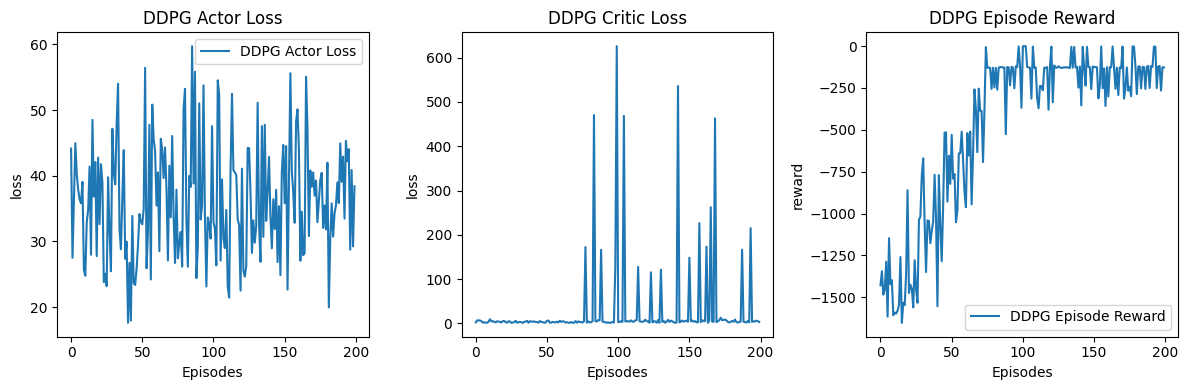

In [74]:
# Plot the results

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(ddpg_actor_losses, label='DDPG Actor Loss')
plt.title('DDPG Actor Loss')
plt.xlabel('Episodes')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.plot(ddpg_critic_losses, label='DDPG Critic Loss')
plt.title('DDPG Critic Loss')
plt.xlabel('Episodes')
plt.ylabel('loss')

plt.subplot(133)
plt.plot(ddpg_rewards, label='DDPG Episode Reward')
plt.title('DDPG Episode Reward')
plt.xlabel('Episodes')
plt.ylabel('reward')
plt.legend()

plt.tight_layout()
plt.show()

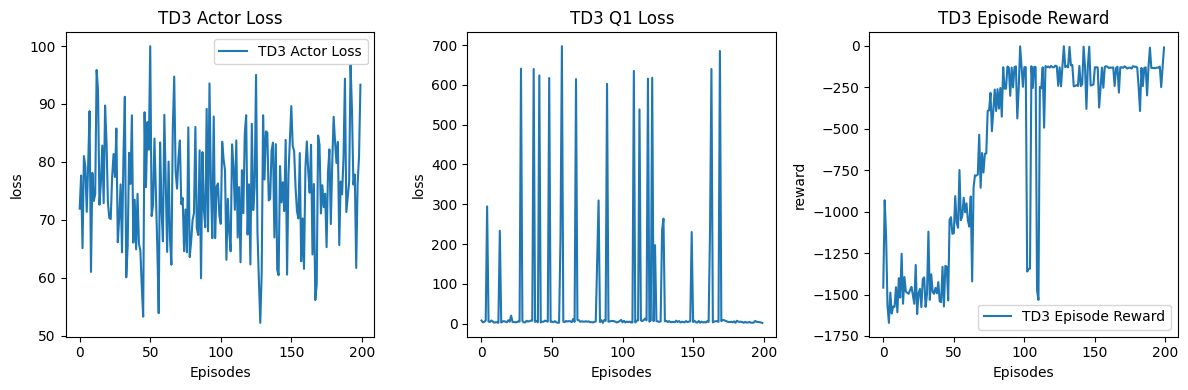

In [75]:
# Plot the results

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(td3_actor_losses, label='TD3 Actor Loss')
plt.title('TD3 Actor Loss')
plt.xlabel('Episodes')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.plot(td3_critic_losses, label='TD3 Critic Loss')
plt.title('TD3 Q1 Loss')
plt.xlabel('Episodes')
plt.ylabel('loss')

plt.subplot(133)
plt.plot(td3_rewards, label='TD3 Episode Reward')
plt.title('TD3 Episode Reward')
plt.xlabel('Episodes')
plt.ylabel('reward')
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [77]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

### 학습 결과 확인

In [78]:
def eval_w_video(env, agent, custom_R = False):
    display = Display(visible=0, size=(1400, 900))
    display.start()
    eval_env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
    state = eval_env.reset()
    eval_reward = 0
    while True:
      eval_env.render()

      action = agent.actor(torch.tensor(state, dtype=torch.float32).cuda()).cpu().detach().numpy()
      action = np.clip(action, -eval_env.action_space.high, eval_env.action_space.high)
      next_state, reward, done, _ = eval_env.step(action)

      if custom_reward:
        reward = custom_reward(state, action)
        eval_reward+= reward
      else:
        eval_reward+= reward

      state = next_state

      if done:
        break;

    eval_env.close()
    show_video()
    print('reward', eval_reward)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 최종 학습 vide 확인

In [79]:
# DDPG 학습 결과 확인
eval_w_video(env, ddpg_agent)

reward 47.36496759832506


In [80]:
# TD3 학습 결과 확인
eval_w_video(env, td3_agent)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reward 48.575045427817315


# Reward customization

In [81]:
import math

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
def custom_reward(observation, action):
    x, y, theta_dot = observation
    theta = math.atan2(x, y)

    toque = action

    # 기존 환경의 reward 함수
    # reward = -theta**2 - 0.1*theta_dot**2 -0.001*toque**2

    # reward 함수 재정의
    reward = 0.1*np.abs(theta_dot)**2 #각속도가 빠를 수록 reward 커지도록 재설정

    return reward

In [83]:
def custom_Reward_train(agent, replay_buffer, max_episodes, max_steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay):
    episode_actor_losses = []
    episode_critic_losses = []
    episode_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        total_reward = 0
        actor_losses = []
        critic_losses = []

        for step in range(max_steps):

            action = agent.exp_action(torch.tensor(state, dtype=torch.float32).cuda()) # exploration 적용된 action 선택
            action = np.clip(action, -env.action_space.high, env.action_space.high)

            next_state, _, done, _ = env.step(action) # 기존 환경에서 계산되는 reward 값 blank 처리
            reward = custom_reward(state, action) # custom reward 함수 값을 통해 reward 값 계산

            replay_buffer.add(state, action, next_state, reward, float(done)) # replay buffer에 trajectory 정보 저장

            state = next_state
            total_reward += reward

            agent.ts += 1
            agent.noise_decay() # 매 timestep마다 noise weight 정도 감소시킴

            if len(replay_buffer.buffer) > batch_size:
                if isinstance(agent, DDPGAgent):
                    actor_loss, critic_loss = agent.train(replay_buffer, batch_size, gamma, tau)
                elif isinstance(agent, TD3Agent):
                    actor_loss, critic_loss = agent.train(replay_buffer, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay)
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)

            if done or step == max_steps - 1:
                episode_actor_losses.append(np.mean(actor_loss))
                episode_critic_losses.append(np.mean(critic_loss))
                episode_rewards.append(total_reward)
                print(f"Episode: {episode}, Total Reward: {total_reward}, Mean Actor Loss: {np.mean(actor_loss)}, Mean Critic Loss: {np.mean(critic_loss)}")
                break

    return actor_losses, critic_losses, episode_rewards

In [84]:
custom_ddpg_agent = DDPGAgent(state_dim, action_dim, max_action, exp_ts, last_exp, actor_learning_rate, critic_learning_rate)
replay_buffer = ReplayBuffer(max_size=buffer_size)
ddpg_actor_losses, ddpg_critic_losses, ddpg_rewards = custom_Reward_train(custom_ddpg_agent, replay_buffer, max_episodes, max_steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay)

Episode: 0, Total Reward: 746.7339432643515, Mean Actor Loss: -3.98349666595459, Mean Critic Loss: 0.1583341360092163
Episode: 1, Total Reward: 78.27744398690567, Mean Actor Loss: -2.080965757369995, Mean Critic Loss: 0.039557624608278275
Episode: 2, Total Reward: 205.8936015678474, Mean Actor Loss: -2.652859926223755, Mean Critic Loss: 0.13086195290088654
Episode: 3, Total Reward: 933.014743569031, Mean Actor Loss: -3.6974730491638184, Mean Critic Loss: 0.1628486067056656
Episode: 4, Total Reward: 194.0177558651715, Mean Actor Loss: -4.90369176864624, Mean Critic Loss: 0.016277657821774483
Episode: 5, Total Reward: 898.5713528842799, Mean Actor Loss: -5.865201473236084, Mean Critic Loss: 0.01898438110947609
Episode: 6, Total Reward: 13.916704305755218, Mean Actor Loss: -4.358429908752441, Mean Critic Loss: 0.01607615128159523
Episode: 7, Total Reward: 873.9261197722572, Mean Actor Loss: -5.991456985473633, Mean Critic Loss: 1.0975801944732666
Episode: 8, Total Reward: 198.574717175722

In [85]:
custom_td3_agent = TD3Agent(state_dim, action_dim, max_action,  exp_ts, last_exp, actor_learning_rate, critic_learning_rate)
replay_buffer = ReplayBuffer(max_size=buffer_size)
td3_actor_losses, td3_critic_losses, td3_rewards = custom_Reward_train(custom_td3_agent, replay_buffer, max_episodes, max_steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_delay)

Episode: 0, Total Reward: 55.70601562265583, Mean Actor Loss: -0.12722916901111603, Mean Critic Loss: 0.0003791393537539989
Episode: 1, Total Reward: 12.817874103042051, Mean Actor Loss: -0.03440296649932861, Mean Critic Loss: 0.00013592696632258594
Episode: 2, Total Reward: 27.201470067590808, Mean Actor Loss: -0.10242864489555359, Mean Critic Loss: 7.183938578236848e-05
Episode: 3, Total Reward: 748.0363211680334, Mean Actor Loss: -1.7291077375411987, Mean Critic Loss: 0.0016518202610313892
Episode: 4, Total Reward: 155.84877623262187, Mean Actor Loss: -1.3700991868972778, Mean Critic Loss: 0.004653714597225189
Episode: 5, Total Reward: 885.2944997692433, Mean Actor Loss: -2.5199692249298096, Mean Critic Loss: 0.003074931213632226
Episode: 6, Total Reward: 152.51327000177832, Mean Actor Loss: -3.2320055961608887, Mean Critic Loss: 0.013324767351150513
Episode: 7, Total Reward: 952.9016995107492, Mean Actor Loss: -3.0167787075042725, Mean Critic Loss: 0.005679870955646038
Episode: 8, 

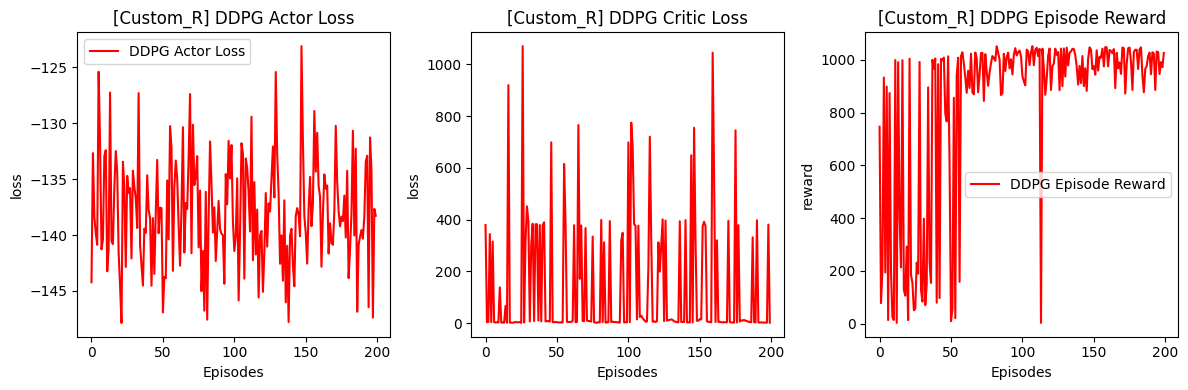

In [86]:
# Plot the results

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(ddpg_actor_losses, label='DDPG Actor Loss', color = 'red')
plt.title('[Custom_R] DDPG Actor Loss')
plt.xlabel('Episodes')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.plot(ddpg_critic_losses, label='DDPG Critic Loss', color = 'red')
plt.title('[Custom_R] DDPG Critic Loss')
plt.xlabel('Episodes')
plt.ylabel('loss')

plt.subplot(133)
plt.plot(ddpg_rewards, label='DDPG Episode Reward', color = 'red')
plt.title('[Custom_R] DDPG Episode Reward')
plt.xlabel('Episodes')
plt.ylabel('reward')
plt.legend()

plt.tight_layout()
plt.show()

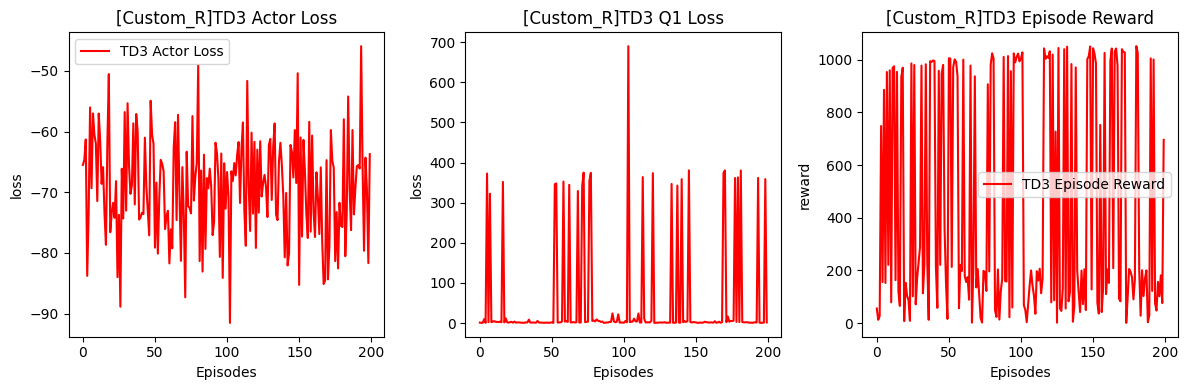

In [87]:
# Plot the results

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(td3_actor_losses, label='TD3 Actor Loss', color='red')
plt.title('[Custom_R]TD3 Actor Loss')
plt.xlabel('Episodes')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.plot(td3_critic_losses, label='TD3 Critic Loss', color='red')
plt.title('[Custom_R]TD3 Q1 Loss')
plt.xlabel('Episodes')
plt.ylabel('loss')

plt.subplot(133)
plt.plot(td3_rewards, label='TD3 Episode Reward', color='red')
plt.title('[Custom_R]TD3 Episode Reward')
plt.xlabel('Episodes')
plt.ylabel('reward')
plt.legend()

plt.tight_layout()
plt.show()

## Custom reward 학습결과 확인
- 각속도의 절댓값을 reward로 설정했기 때문에 전반적으로 진자를 빠르게 돌리는 방향으로 학습된 것을 확인할 수 있음

In [88]:
# Custom reward DDPG 학습 결과 확인
eval_w_video(env, custom_ddpg_agent, custom_R=True)

reward 1045.987790760704


In [89]:
# Custom reward td3 학습 결과 확인
eval_w_video(env, custom_td3_agent, custom_R=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reward 169.9902912550525
